# sprint sep2sep

 # 【問題1】機械翻訳の実行とコードリーディング

In [1]:
! http://www.manythings.org/anki/fra-eng.zip

/bin/sh: http://www.manythings.org/anki/fra-eng.zip: No such file or directory


In [4]:
!unzip fra-eng.zip

unzip:  cannot find or open fra-eng.zip, fra-eng.zip.zip or fra-eng.zip.ZIP.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [6]:
from __future__ import print_function

from  keras.models import Model
from keras.layers import Input , LSTM , Dense
from keras.callbacks import EarlyStopping

In [11]:
# ハイパーパラメーター
batch_size = 64
epochs = 2
latent_dim = 256
num_samples = 10000
data_path = "/Users/shinoda/diveintocode-ml/ML2001_sprint/fra-eng/fra.txt"

In [8]:
# データのベクトル化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

#データファイルの読み込み
with open(data_path , "r" , encoding="utf-8") as f:
  lines = f.read().split("\n") #改行で文字列を分割している
#データの前処理
for line in lines[: min(num_samples , len(lines) - 1)]:
  input_text , target_text , _ = line.split("\t")
  target_text = "\t" + target_text + "\n"
  input_texts.append(input_text)
  target_texts.append(target_text)
  for char in input_text:
    if char not in input_characters:
      input_characters.add(char)
  for char in target_text:
    if char not in target_characters:
      target_characters.add(char)
    
input_characters = sorted(list(input_characters)) #文字を順番に並べる
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters) #文字の数
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])#txtの中の最大数の文字
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [9]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_dataはdecoder_input_dataより1タイムステップだけ進んでいます
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decode_target_dataは1タイムステップ先になります
            # 開始文字は含まれません。
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# 入力シーケンスを定義して処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# 「encoder_outputs」を破棄し、状態のみを保持します。
encoder_states = [state_h, state_c]

In [12]:
# 初期状態として「encoder_states」を使用して、デコーダーをセットアップします。
decoder_inputs = Input(shape=(None, num_decoder_tokens))
#完全な出力シーケンスを返すようにデコーダを設定し、
#また、内部状態も返します。
#トレーニングモデルでは戻り状態を使用しませんが、推論では使用します。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#回転するモデルを定義する
#「encoder_input_data」と「decoder_input_data」を「decoder_target_data」に
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
early_stopping = EarlyStopping(monitor="val_loss", patience=10) 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          callbacks=[early_stopping])
# Save model
model.save('s2s.h5')

#次：推論モード（サンプリング）。
#ドリルは次のとおりです。
#1）入力をエンコードし、初期デコーダー状態を取得する
#2）この初期状態でデコーダーの1ステップを実行する
#およびターゲットとしての「シーケンスの開始」トークン。
#出力は次のターゲットトークンになります
#3）現在のターゲットトークンと現在の状態で繰り返します

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
     [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Train on 8000 samples, validate on 2000 samples
Epoch 1/2
8000/8000 [==============================] - 102s 13ms/step - loss: 1.1084 - accuracy: 0.7286 - val_loss: 1.2075 - val_accuracy: 0.7000
Epoch 2/2
8000/8000 [==============================] - 102s 13ms/step - loss: 0.8465 - accuracy: 0.7734 - val_loss: 0.8443 - val_accuracy: 0.7684
-
Input sentence: Go.
Decoded sentence: Tomes                                                       
-
Input sentence: Hi.
Decoded sentence: Je s                                                        
-
Input sentence: Hi.
Decoded sentence: Je s                                                        
-
Input sentence: Run!
Decoded sentence: Je s                                                        
-
Input sentence: Run!
Decoded sentence: Je s                                                        
-
Input sentence: Who?
Decoded sentence: Je s                                                        
-
Input sentence: Wow!
Decoded sentence: Je s      

# 【問題2】イメージキャプショニングの学習済みモデルの実行

In [30]:
! git clone https://github.com/yunjey/pytorch-tutorial.git


fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [33]:
cd pytorch-tutorial

/Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial


In [14]:
#!cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

In [21]:
import os

In [24]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2020-04-03 15:59:03--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
www.dropbox.com (www.dropbox.com) をDNSに問いあわせています... 162.125.80.1
www.dropbox.com (www.dropbox.com)|162.125.80.1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 Moved Permanently
場所: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [続く]
--2020-04-03 15:59:03--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
www.dropbox.com:443 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://uc1eab16722c61e3a6edea00a4d5.dl.dropboxusercontent.com/cd/0/inline/A1LBgB1lRJ8STD7ovXGO0hSQOvVQLsacMxQ4jl6lJQ-6v1mZL1YZV8KG6V0iUOhTpazLdy0J1RRWRv_HQMu7Wskgt8o9PgRceuPPDsc11UoP54ZedHEHtf5Iyqop3nm_m7I/file# [続く]
--2020-04-03 15:59:03--  https://uc1eab16722c61e3a6edea00a4d5.dl.dropboxusercontent.com/cd/0/inline/A1LBgB1lRJ8STD7ovXGO0hSQOvVQLsacMxQ4jl6lJQ-6v1mZL1YZV8KG6V0iUOhTpazLdy0J1RRWRv_HQMu7Wskgt8o9PgRceuPPDsc11UoP54ZedHEHtf5Iyqop3nm_m7I/file
uc1eab16722c61e3a6edea00a4d5.dl.dro

In [25]:
!unzip pretrained_model.zip?dl=0

Archive:  pretrained_model.zip?dl=0
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [26]:
! wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2020-04-03 16:03:13--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
www.dropbox.com (www.dropbox.com) をDNSに問いあわせています... 162.125.80.1
www.dropbox.com (www.dropbox.com)|162.125.80.1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 Moved Permanently
場所: /s/raw/26adb7y9m98uisa/vocap.zip [続く]
--2020-04-03 16:03:13--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
www.dropbox.com:443 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 302 Found
場所: https://uc02cbc4906722efc34c6a38f4af.dl.dropboxusercontent.com/cd/0/inline/A1JuOUMfmGzLB1JN4ObMzkhlwcEfRnecLGEO8nyF6Nt9JW_x-dYAzXtQ8i4__3FPlq6aPWm9SQ7I6rprlNiGVcoQCVGPbqVTDdowti0OlIDkNjDNMTWdyxlvM4otMY1iolU/file# [続く]
--2020-04-03 16:03:13--  https://uc02cbc4906722efc34c6a38f4af.dl.dropboxusercontent.com/cd/0/inline/A1JuOUMfmGzLB1JN4ObMzkhlwcEfRnecLGEO8nyF6Nt9JW_x-dYAzXtQ8i4__3FPlq6aPWm9SQ7I6rprlNiGVcoQCVGPbqVTDdowti0OlIDkNjDNMTWdyxlvM4otMY1iolU/file
uc02cbc4906722efc34c6a38f4af.dl.dropboxusercontent.com (uc02cbc49067

In [27]:
! unzip vocap.zip?dl=0

Archive:  vocap.zip?dl=0
  inflating: vocab.pkl               


In [32]:
! git clone https://github.com/yunjey/pytorch-tutorial

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [36]:
!pwd

/Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial


In [37]:
!cd tutorials/03-advanced/image_captioning

In [38]:
!pwd

/Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial


In [39]:
cd /Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial/tutorials/03-advanced/image_captioning/

/Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [40]:
mkdir sprint24_image

In [41]:
rm sprint24_image

rm: sprint24_image: is a directory


In [42]:
mkdir sprint24_ward

In [44]:
!mv /Users/shinoda/diveintocode-ml/ML2001_sprint/vocap.zip?dl=0 sprint24_image

In [45]:
!mv /Users/shinoda/diveintocode-ml/ML2001_sprint/pretrained_model.zip?dl=0 sprint24_ward

In [46]:
!pwd

/Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [47]:
mkdir models

In [48]:
mkdir data

In [49]:
!mv /Users/shinoda/diveintocode-ml/ML2001_sprint/vocab.pkl data

In [50]:
!mv /Users/shinoda/diveintocode-ml/ML2001_sprint/encoder-5-3000.pkl models

In [51]:
!mv /Users/shinoda/diveintocode-ml/ML2001_sprint/decoder-5-3000.pkl models

In [58]:
!python sample.py --image='cat_0_324.jpg'

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /Users/shinoda/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|████████████████████████████████████████| 230M/230M [00:09<00:00, 24.8MB/s]
<start> a cat is sitting on a couch next to a cat . <end>


In [53]:
!pwd

/Users/shinoda/diveintocode-ml/ML2001_sprint/pytorch-tutorial/tutorials/03-advanced/image_captioning


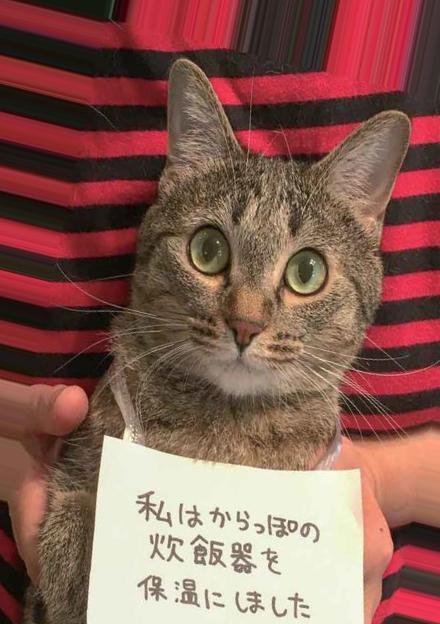

In [59]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('cat_0_324.jpg'))

# 【問題3】Kerasで動かしたい場合はどうするかを調査¶

解決方法：MMdnnを使う

MMdnnとは、Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール。中間表現を経由することで様々なフレームワーク間でのモデルデータの相互変換を実現する。 モデルの相互運用が可能なフレームワークは、Caffe, Keras, Tensorflow, CNTK, MXNet, PyTorch, CoreML。 テスト済みのモデルとしては、 VGG19、Inception v4、ResNet v2、SqueezeNet　あたりは全フレームワークで利用可能。 代表的なモデルに対応していれば、実用面ではあまり壁を感じないのではないかと感じる。。 多くの場合は代表的なモデルの転移学習だったり、もっとシンプルなモデルだったりするため、非常に有能である。

mmconvert -sf keras -iw imagenet_inception_v3.h5 -df onnx -om imagenet_inception_v3.onnxで、「imagenet_inception_v3.h5」というkerasモデルファイルに対して、「imagenet_inception_v3.onnx」というファイルが生成される。それにより、モデルをONNXモデルに変換できる。

https://qiita.com/koppe/items/7f85f5411539390c4499